In [1]:
import numpy as np
import h5py, os, cv2
import matplotlib.pyplot as plt

In [2]:
base_path = 'dataset/original'
train_data = h5py.File(os.path.join(base_path, "train_happy.h5"), "r")

In [8]:
x_train = np.array(train_data["train_set_x"][:])
y_train = np.array(train_data["train_set_y"][:])

In [9]:
test_data = h5py.File(os.path.join(base_path, "test_happy.h5"), "r")
x_test = np.array(test_data["test_set_x"][:])
y_test = np.array(test_data["test_set_y"][:])

In [10]:
np.save("dataset/x_train_color.npy", x_train)
np.save("dataset/x_test_color.npy", x_test)

In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(600, 64, 64, 3) (600,)
(150, 64, 64, 3) (150,)


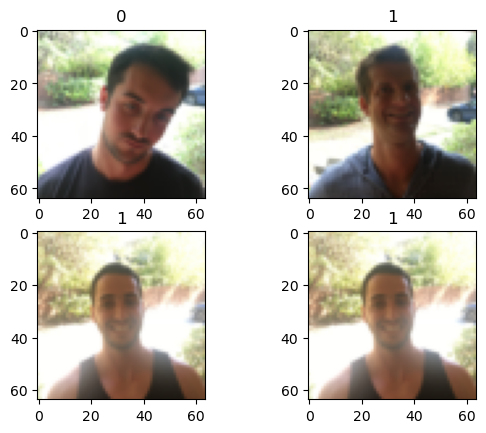

In [16]:
plt.subplot(2,2,1)
plt.title(y_train[0])
plt.imshow(x_train[0])
plt.subplot(2,2,2)
plt.title(y_train[1])
plt.imshow(x_train[1])
plt.subplot(2,2,3)
plt.title(y_test[0])
plt.imshow(x_test[0])
plt.subplot(2,2,4)
plt.title(y_test[0])
plt.imshow(x_test[0])

In [17]:
x_result = []
for x in x_train:
    img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    x_result.append(img)

x_result = np.array(x_result)
np.save("dataset/x_train.npy", x_result)

x_result = []
for x in x_test:
    img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    x_result.append(img)

x_result = np.array(x_result)
np.save("dataset/x_test.npy", x_result)

In [19]:
np.save("dataset/y_train.npy", y_train)
np.save("dataset/y_test.npy", y_test)

In [20]:
plt.style.use("dark_background")


In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [23]:
base_path = "dataset"

In [24]:
x_train = np.load(os.path.join(base_path, "x_train.npy"))
x_test = np.load(os.path.join(base_path, "x_test.npy"))
y_train = np.load(os.path.join(base_path, "y_train.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

In [25]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(600, 64, 64) (600,)
(150, 64, 64) (150,)


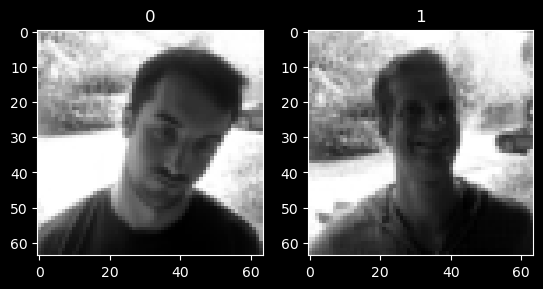

In [26]:
plt.subplot(1, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1], cmap='gray')

In [30]:
inputs = Input(shape=(64,64,1))

net = Conv2D(filters = 64, kernel_size = 3, strides =2 , padding = "same")(inputs)

net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(units = 64)(net)
net = Activation('relu')(net)

net = Dense(units = 1)(net)
outputs = Activation("sigmoid")(net)


from keras.models import Model, Sequential, load_model
model = Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics =["acc"])

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65    

In [32]:
x_train = x_train.reshape((-1,64,64,1))
x_test = x_test.reshape((-1,64,64,1))

In [33]:
train_data_gen = ImageDataGenerator(
                    samplewise_center = True,
                    samplewise_std_normalization = True,
                    brightness_range = [0.5, 1.5],
                    zoom_range = [0.8, 1.1],
                    rotation_range= 15,
                    channel_shift_range = 25,
                    horizontal_flip = True)

In [34]:
test_data_gen = ImageDataGenerator(
                 samplewise_center = True,
                 samplewise_std_normalization = True)

In [35]:
train_batch_gen = train_data_gen.flow(x_train, y_train, batch_size = 16, shuffle = True)
test_batch_gen = test_data_gen.flow(x_test, y_test, batch_size = 16, shuffle = False)

In [36]:
model.fit_generator(
    train_batch_gen,
    epochs=20,
    validation_data=test_batch_gen,
    callbacks=[
        ModelCheckpoint('models/happy.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

C:\Users\kijun\AppData\Local\Temp\ipykernel_18568\342911500.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.9702 - acc: 0.5733
Epoch 1: val_acc improved from -inf to 0.53333, saving model to models\happy.h5
38/38 [==============================] - 4s 68ms/step - loss: 0.9702 - acc: 0.5733 - val_loss: 0.6440 - val_acc: 0.5333 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.6061 - acc: 0.6817
Epoch 2: val_acc improved from 0.53333 to 0.62667, saving model to models\happy.h5
38/38 [==============================] - 2s 64ms/step - loss: 0.6061 - acc: 0.6817 - val_loss: 0.6450 - val_acc: 0.6267 - lr: 0.0010
Epoch 3/20
37/38 [============================>.] - ETA: 0s - loss: 0.5604 - acc: 0.7021
Epoch 3: val_acc improved from 0.62667 to 0.70667, saving model to models\happy.h5
38/38 [==============================] - 3s 73ms/step - loss: 0.5612 - acc: 0.7000 - val_loss: 0.5283 - val_acc: 0.7067 - lr: 0.0010
Epoch 4/20
37/38 [============================>.] - ETA: 0s - loss: 0.5540 - acc: 0.6884

In [37]:
x_test_input = x_test.copy().astype(np.float64)
x_test_input -= np.mean(x_test, keepdims=True)
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

y_pred = model.predict(x_test_input)

y_pred_logical = (y_pred > 0.5).astype(np.int)

C:\Users\kijun\AppData\Local\Temp\ipykernel_18568\3153863459.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_logical = (y_pred > 0.5).astype(np.int)


test acc: 0.8866666666666667


<Axes: >

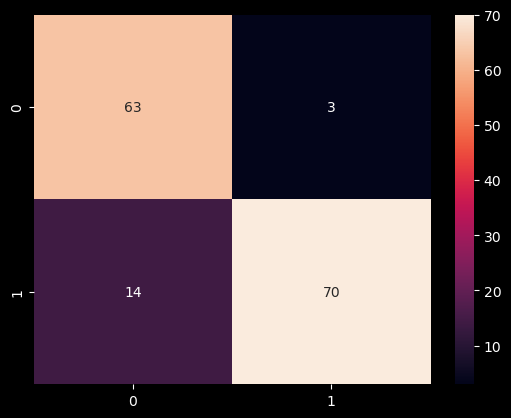

In [38]:
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))

cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)

In [1]:
print()